# Prediction and Supervised Learning

Today, we'll learn about making prediction when we have an example dataset at our disposal. In class, we've learned about using both the *graph of averages* and the *regression line* to make a prediction about one characteristic based on another characteristic. When the characteristics are linearly associated, these two methods are equivalent.

The techniques we'll use today are more general, non-linear techniques:
1. *k nearest neighbors* (k-NN), 
2. *decision tree models*
3. *random forests*.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from datascience import *

### Prediction functions: regression

Suppose we want to predict some characteristic $y$ from a dataset with characteristics (columns) named $x_1,\ldots,x_n$. To do this, we look for a *prediction function* $y = f(x_1,\ldots,x_n)$ that takes our known characteristics to a best guess for $y$.

The regression line is a *linear prediction function* $f(x) = mx + b$ that predicts the value $y = mx + b$ for a given input $x$. 

In the plot below, the regression line predicts a value of $y \approx 1.2$ at the input $x = 101$.

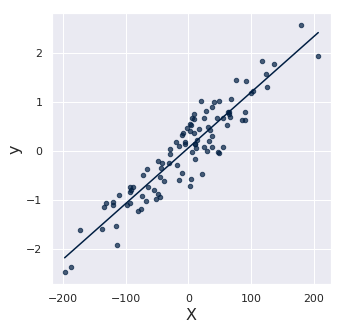

In [2]:
from sklearn.datasets.samples_generator import make_regression
y, X = make_regression(100, 1, noise=30)

Table().with_columns('X',X, 'y', y.reshape(-1)).scatter(0, fit_line=True)

The scatterplot below depicts the heights and weights of nba players in 2013. The regression line predicts a rookie (not in our dataset) of height 85 inches should weight approximately 260 lbs.

In [49]:
nba

Name,Position,Height,Weight,Age
DeQuan Jones,Guard,80,221,23
Darius Miller,Guard,80,235,23
Trevor Ariza,Guard,80,210,28
James Jones,Guard,80,215,32
Wesley Johnson,Guard,79,215,26
Klay Thompson,Guard,79,205,23
Thabo Sefolosha,Guard,79,215,29
Chase Budinger,Guard,79,218,25
Kevin Martin,Guard,79,185,30
Evan Fournier,Guard,79,206,20


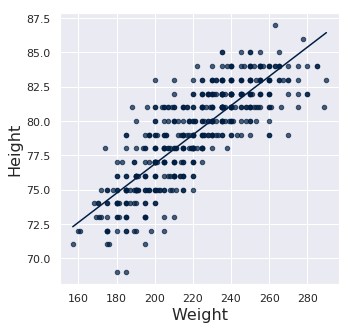

In [7]:
nba = Table.read_table('data/nba2013.csv')
nba.select('Height', 'Weight').scatter(1, fit_line=True)

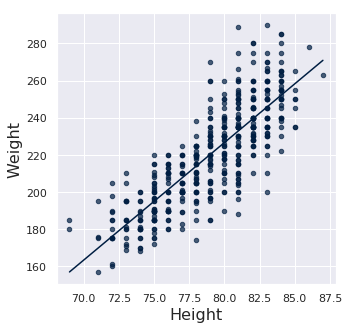

In [8]:
nba.select('Height', 'Weight').scatter(0, fit_line=True)

## Fitting the prediction function

There are many ways to fit a prediction function to a dataset, so how do we know which is the 'correct' way?

For example, are height and weight in the nba dataset really linearly associated? Should've we fit the data with a non-linear prediction function?

Below, we calculate the graph of averages prediction function and see that the prediction curve we get does *not* look linear near the tails of the height distribution!

In [9]:
def graph_of_averages(x):
    nearby = nba.where('Height', are.between_or_equal_to(x - 1, x + 1))
    return np.mean(nearby.column('Weight'))

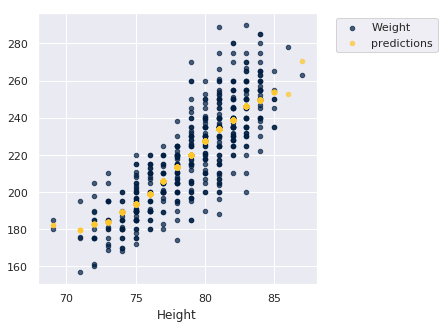

In [10]:
goa_out = nba.select('Height', 'Weight').with_column('predictions', nba.apply(graph_of_averages, 'Height'))
goa_out.scatter(0)

How do we know which prediction function is best? Does the non-linear predictor only look better because there are fewer data points at the ends of the distribution, and the plot is overly concerned with only a few examples?

This concept is known as the bias-variance trade-off: you want your predictor to predict the correct value, without learning the random noise in the data (this is called *overfitting*). You want your predictor to learn the *pattern*, not the noise.

![overfit](under-over-fit.png)

## Splitting your data for accuracy

To search for the best predictor while avoiding overfitting your data, you want to split your data set into *training set* and a *test set*. 

* The training set is used to *train* your predictor.
* The test set is used to *test* the goodness-of-fit of your trained predictor.

By leaving out data for testing, you are ensuring that the best predictor you find is the one that best learns the patterns in the data, and not the data points themselves!

## The machine learning training pipeline:

![pipeline](train-test.png)

Scikit-Learn as functions that help us do this. Let's look at the problem of predicting heights from weights in the nba dataset, and find the best predictor.

In [12]:
from sklearn.model_selection import train_test_split

help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int or None, optional (default=0.25)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, 

In [13]:
X = nba.column('Height').reshape(-1,1) # input attributes
y = nba.column('Weight') # what we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Picking three possible predictors

From the scikit library, we'll try the following three predictors:
1. k-nearest-neighbors regression: find the closest k data points from a given data point, and average their values. That average is the prediction.
2. linear regression: using the line of 'best fit' in the training set to predict values in the test set.
3. support-vector regression: find a non-linear curve of 'best fit' to the training set to predict values in the test set.

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [15]:
# fit 5-nearest neighbors regressor
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

# fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# fit support-vector-regressor
svr = SVR()
svr.fit(X_train, y_train);

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Now that each prediction function is fit on the training set, we'll evaluate the predictions on the test set.

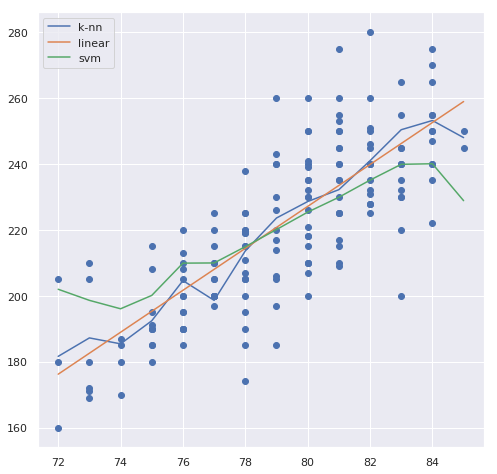

In [18]:
t = Table().with_columns(
    'X test', X_test.flatten(),
    'y test', y_test,
    'prediction knr', knr.predict(X_test),
    'prediction lr', lr.predict(X_test),
    'prediction svr', svr.predict(X_test)
).sort('X test')


plt.figure(figsize=(8,8))
plt.scatter(t.column(0), t.column(1))
plt.plot(t.column(0), t.column(2))
plt.plot(t.column(0), t.column(3))
plt.plot(t.column(0), t.column(4))
plt.legend(['k-nn', 'linear', 'svm']);

The scikit learn library also scores quality of the predictions. In the case of regression, the score is given by 

$$R^2 = (1 - u/v)$$

where 
1. $u$ is the sum of the squares of the errors: `u = np.sum((y_test - y_pred) ** 2)`
2. $v$ is the sum of the squares of the deviation from the average: `v = np.sum((y_test - y_test.mean()) ** 2)`

Thus, the best possilbe score is 1.0 (when the errors are 0). A constant model that always predictions the mean value of the true values (disregarding input features) would have a value of 0.0.

In [19]:
print(
    "k-nn score:\t\t\t\t%f" % knr.score(X_test, y_test),
    "linear regression score:\t\t%f" % lr.score(X_test, y_test),
    "support vector regression score:\t%f" % svr.score(X_test, y_test),
    sep='\n'
)

k-nn score:				0.605092
linear regression score:		0.623619
support vector regression score:	0.553072


So the linear model performed best on the test set!

## Classification

Up until now, we've focused on *regression* problems, where our prediction function is trying to predict real numbers in its output. However, what if our prediction function $y = f(x)$ is trying to learn a finite number of labels, instead? This is problem is called the *classification* problem.

As an example, suppose we are trying to learn the nba players position based on `Height` and `Weight` -- that is, we are trying to learn a prediction function:

$$y = f(h, w)$$

Where $h$ is a players height, $w$ is a players weight, and $y$ is one of the values {guard, forward, center}. Much of the process of fitting our prediction function will remain the same, however the learning algorithms and the way we evaluate them will change.

In [56]:
X = nba.select('Height', 'Weight').values
y = nba.column('Position')

X_test, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ValueError: too many values to unpack (expected 2)

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
tr = DecisionTreeClassifier(max_depth=5)
tr.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
out = Table().with_columns(
    'Height', X_test[:,0],
    'Weight', X_test[:,1],
    'true', y_test,
    'pred', tr.predict(X_test),
    'correct', np.where(y_test == tr.predict(X_test), 'correct', 'incorrect')
)
out.join('Height', nba).

Height,Weight,true,pred,correct,Name,Position,Weight_2,Age
72,180,Guard,Guard,correct,Ish Smith,Guard,175,25
72,180,Guard,Guard,correct,Chris Paul,Guard,175,28
72,180,Guard,Guard,correct,Darren Collison,Guard,160,26
72,180,Guard,Guard,correct,J.J. Barea,Guard,175,29
72,180,Guard,Guard,correct,Patty Mills,Guard,185,25
72,180,Guard,Guard,correct,Isaiah Canaan,Guard,198,22
72,180,Guard,Guard,correct,Aaron Brooks,Guard,161,28
72,180,Guard,Guard,correct,Mickey McConnell,Guard,189,24
72,180,Guard,Guard,correct,Jameer Nelson,Guard,190,31
72,180,Guard,Guard,correct,Will Bynum,Guard,185,30


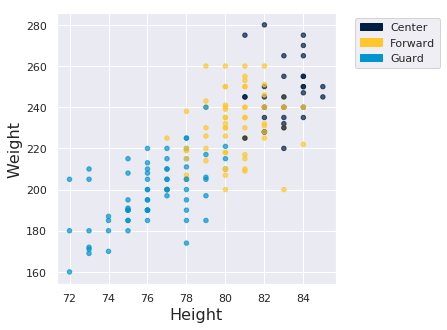

In [35]:
# true distribution
out.scatter(0,1, colors='true')

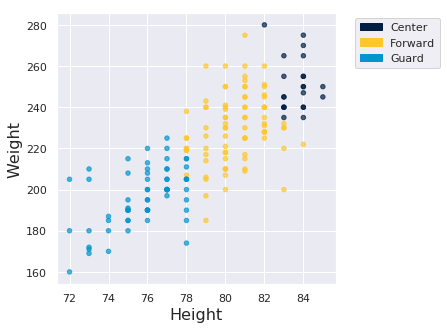

In [36]:
# prediction distribution 
out.scatter(0,1, colors='pred')

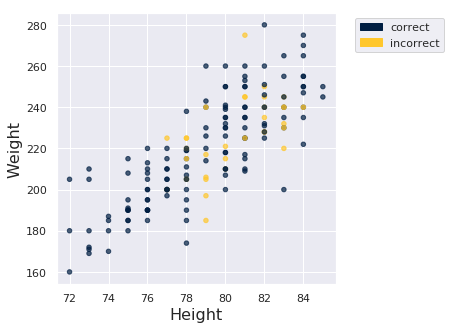

In [37]:
out.scatter(0,1, colors='correct')

The score method computes the *accuracy* of the classifier: the proportion of instances were correctly classified.

In [38]:
# accuracy via the score function
tr.score(X_test, y_test)

0.8023952095808383

In [39]:
# accuracy using the definition
np.mean(tr.predict(X_test) == y_test)

0.8023952095808383

We can also see the decision tree logic by looking inside the fit classifier. The function returns the number of labels in the training set seen for that branch of the tree. The prediction function would predict the most common value in each branch.

In [40]:
from print_tree import tree_to_code
tree_to_code(tr, ['Height', 'Weight'])

def tree(Height, Weight):
  if Height <= 78.5:
    if Height <= 77.5:
      return [[  0.   0. 109.]]
    else:  # if Height > 77.5
      if Weight <= 206.0:
        return [[0. 0. 7.]]
      else:  # if Weight > 206.0
        if Weight <= 216.5:
          if Weight <= 207.5:
            return [[0. 1. 0.]]
          else:  # if Weight > 207.5
            return [[0. 2. 4.]]
        else:  # if Weight > 216.5
          if Weight <= 221.0:
            return [[0. 4. 1.]]
          else:  # if Weight > 221.0
            return [[0. 3. 2.]]
  else:  # if Height > 78.5
    if Height <= 82.5:
      if Height <= 81.5:
        if Height <= 79.5:
          if Weight <= 219.0:
            return [[0. 8. 7.]]
          else:  # if Weight > 219.0
            return [[ 0. 20.  1.]]
        else:  # if Height > 79.5
          if Weight <= 228.5:
            return [[ 0. 30.  0.]]
          else:  # if Weight > 228.5
            return [[ 3. 38.  1.]]
      else:  # if Height > 81.5
        if Weigh

## Next steps

* Change the parameters for the descision tree (e.g. set max-depth higher). Which choice of parameters give the best accuracy on the test set?
* Look into the predictions more closely:
    - which positions are misclassified most?
    - who are the players being misclassified?
* Try other classification algorithms, such as `RandomForestClassifier` and `KNeighborsClassifier` imported below.
* Use the `nba2016` dataset, and try to predict player positions based on player statistics.
* Use the SDPD traffic stops datasets. 
    - Can you predict the age/gender/ethnicity based on other factors? (which are regression? classification?)
    - Can you predict who will be search or arrested, based on attributes of the stopped driver?

In [41]:
from sklearn.ensemble import RandomForestClassifier  # Votes of many decision trees
from sklearn.neighbors import KNeighborsClassifier # Votes of nearest neighbors

In [48]:
most_misclassified_positions = out.where('correct', are.equal_to('incorrect')).group('pred').sort('count', descending=True).column(0).item(0)